<a href="https://colab.research.google.com/github/arnauldnzegha/deep2pde_Berg_Nystrom/blob/master/Face_recognition_using_cnn_on_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multimodale fusion for authentication: face + fingerprinter

This notebook presente a multimodale fusion approch to inprouve authentication systeme accuracy. 

This has key importance in real-time systems as long as the autentifiacation of any modality is not 100% guaranteed. 

This routine load the training data set form google drive and unzip it in "DATA2/"

In [1]:
##*****************LOAD AND UNZIP******************************
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
zip_id = '1dx5RX4wG7ccvUEHRXO4-FfGE1ZePdlQa'
if not os.path.exists('DATA2'):
    os.makedirs('DATA2')
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('DATA2/')
zip_ref.close()

     |████████████████████████████████| 993kB 2.9MB/s 


Here, there is all usefull importations

In [2]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from keras.utils import np_utils
from PIL import Image
import cv2
import numpy as np
import warnings
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import SGD,Adadelta
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Input, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from random import shuffle
from keras.preprocessing.image import load_img, img_to_array, array_to_img

Using TensorFlow backend.


This function mix 

In [0]:
def load_trainSet():
    root="DATA2"
    folders = os.listdir(root)
    nb = len(folders)
    x_data=[]
    y_label=[]
    for x in range(nb):
        label=np.zeros(nb)
        label[x]=1
        facesPath=os.listdir(root+"/"+folders[x])
        faces=[root+"/"+folders[x]+"/"+f for f in facesPath if f.endswith(".png")]
        for face in faces:
            img=cv2.imread(face)
            x_data.extend([img])
            y_label.extend([label])
    return (np.asarray(x_data), np.asarray(y_label), nb)

In [0]:
def mixData(xs,ys):
    xys=[]
    for i in range(0,len(xs)-1):
        xys.append((xs[i],ys[i]))
    shuffle(xys)
    x2,y2=[],[]
    for (x,y) in xys:
        x2.append(x)
        y2.append(y)
    return (np.asarray(x2), np.asarray(y2))
#X_train, Y_train=mixData(X_train, Y_train)

In [0]:
def save_weights_in_drive(model, filename):
  from google.colab import files
  model.save_weights('my_model_weights_fam.h5')
  uploaded = drive.CreateFile({'title': 'my_model_weights_fam.h5'})
  uploaded.SetContentFile('model_weights_AUG_300.h5')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

T

In [0]:
def fr_model(input_shape,nb_person=1):
    img_input = Input(shape=input_shape)
    #Block 1 avec 64 filtre
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_1')(img_input)
    x=BatchNormalization()(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)
    x= Dropout(0.25)(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_2')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)
    x= Dropout(0.25)(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_2')(x)
    x=BatchNormalization()(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)
    x= Dropout(0.25)(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_3')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
    x= Dropout(0.25)(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_3')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    x= Dropout(0.25)(x)

    #Classifieur du modele
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc6')(x)
    x= Dropout(0.25)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dense(nb_person, activation='softmax', name='fc8')(x)
    model = Model(img_input, x)
    return model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
if __name__ == '__main__':
    import copy
    (x_train, y_train, nb_class)=load_trainSet()
    (x_train, y_train)=mixData(x_train, y_train)
    model = fr_model(nb_person=nb_class, input_shape=x_train[0].shape)
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    delta=Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=delta,  metrics=['accuracy'])
    print("Entrainement du modele")
    tr,v=len(x_train)-300,len(x_train)-1
    hist=model.fit_generator(datagen.flow(x_train[:tr], y_train[:tr], batch_size=32),
                    steps_per_epoch=len(x_train) / 32, validation_data =(x_train[tr:v], y_train[tr:v]), epochs=80, verbose=1)
    #hist=model.fit(x_train, y_train, validation_split=0.33, batch_size=50, epochs=1000, verbose=0)

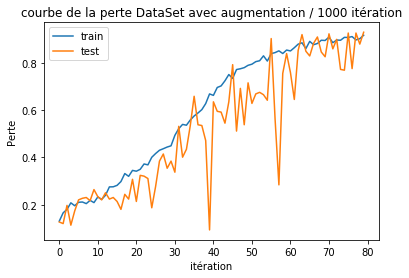

In [10]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('courbe de la perte DataSet avec augmentation / 1000 itération')
plt.ylabel('Perte')
plt.xlabel('itération')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test predictions

In [11]:
(x, y, _)=load_trainSet()
print(len(x))
test=model.predict(x_train[tr:v])
test2=model.evaluate(x_train[tr:v], y_train[tr:v])
list_id=np.argmax(test, axis=1)
print(test2)
print(list_id)
print(np.argmax(y_train[tr:v], axis=1))

2136
299/299 [==============================] - 1s 3ms/step
[0.23339815507565054, 0.9297658872843586]
[6 6 5 3 7 0 5 8 9 7 0 3 2 0 7 7 0 7 2 1 8 3 8 0 0 9 7 0 6 6 7 7 5 8 5 8 9
 2 5 1 8 7 5 8 1 8 5 8 7 3 2 8 2 5 5 5 3 0 1 5 8 5 2 5 2 5 5 7 4 8 8 6 6 5
 5 7 1 1 0 7 4 5 7 0 1 0 9 9 7 5 3 6 2 7 6 1 4 1 4 4 3 5 4 7 7 1 2 1 7 8 0
 6 8 7 2 2 1 7 3 5 0 3 7 1 2 5 5 2 8 4 3 3 5 5 9 9 5 2 3 5 5 1 1 1 1 5 3 7
 1 4 0 7 3 1 8 6 1 5 3 1 3 1 7 3 5 6 8 5 1 5 2 7 7 4 8 8 2 3 9 7 1 7 7 7 2
 1 7 4 7 5 9 8 6 0 5 5 7 1 3 7 1 3 7 4 1 8 7 3 4 6 1 8 0 7 0 8 8 9 9 8 0 0
 7 5 1 4 0 5 2 0 3 1 5 5 3 8 0 1 8 0 0 0 2 0 7 4 0 5 5 0 1 8 4 8 5 6 7 6 8
 5 5 7 6 9 9 8 5 2 5 2 7 5 1 0 6 7 0 8 5 3 0 1 4 8 8 5 6 1 0 6 5 8 0 0 7 6
 5 5 9]
[6 6 5 3 7 0 5 8 9 7 0 3 2 0 7 7 0 7 2 1 8 3 8 0 0 7 7 3 6 6 7 7 5 8 5 8 9
 2 5 1 8 7 5 8 3 8 5 8 7 3 2 8 2 5 5 5 3 0 1 5 8 5 2 5 2 5 5 7 4 8 8 6 6 5
 5 7 3 1 0 7 4 5 7 0 1 0 9 9 7 5 3 6 2 7 6 1 1 3 4 4 3 5 4 7 7 9 2 1 7 8 0
 6 8 7 2 2 1 7 0 5 0 3 7 3 2 5 5 2 8 7 3 3 5 5 9 9 5 2 3 5 5 1 3 